# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.metrics import 
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

Импортирую нужные библиотеки

In [2]:
RANDOM_STATE = 42
budget = 10_000_000_000
income_per_unit = 450000
num_points = 500
num_best_points = 200
bootstrap_n_iter = 200

Константные значения

In [39]:
# Функция для визуализации количественных значений
def num_plot(data,columns):
    for column in columns:
        #Гистограмма
        plt.figure(figsize=(12,3))
        plt.subplot(1,2,1)
        sns.histplot(data=data,x=column,bins=50)
        plt.title(f'Гистограмма {column}')
        plt.ylabel('Частота')
        plt.xlabel(f'Значения {column}')
        plt.grid()
        #Boxplot
        plt.subplot(1,2,2)
        sns.boxplot(data=data,y=column)
        plt.title(f'Boxplot {column}')
        plt.ylabel(f'Распределение {column}')
        plt.xlabel('Boxplot график')
        plt.grid()
        plt.show()

# Функция для визуализации Heatmap
def heatmap(data,title):
    plt.figure(figsize=(12,6))
    sns.heatmap(data.corr(),annot=True,cmap='coolwarm',cbar=True)
    plt.title(f'Корреляционная матрица {title}')
    plt.show()

#График линейной зависимости
def scatterplot(data,columns):
    plt.figure(figsize=(15,7))
    #f0
    plt.subplot(1,3,1)
    sns.scatterplot(data=data,x=columns[0],y='product')
    plt.title(f'Распределение {columns[0]} относительно product')
    plt.xlabel(f'{columns[0]}')
    plt.ylabel(f'product')
    #f1
    plt.subplot(1,3,2)
    sns.scatterplot(data=data,x=columns[1],y='product')
    plt.title(f'Распределение {columns[1]} относительно product')
    plt.xlabel(f'{columns[1]}')
    plt.ylabel(f'product')
    #f2
    plt.subplot(1,3,3)
    sns.scatterplot(data=data,x=columns[2],y='product')
    plt.title(f'Распределение {columns[2]} относительно product')
    plt.xlabel(f'{columns[2]}')
    plt.ylabel(f'product')
    plt.show()

#Вычисляет прибыль от разработки 200 лучших скважин из 500
def profit(target, predictions):
    predictions_data = pd.Series(predictions).reset_index(drop=True)  # сброс индекса
    target = target.reset_index(drop=True)                            # сброс индекса

    selected_index = predictions_data.sort_values(ascending=False).index[:num_best_points]
    selected_target = target.iloc[selected_index]  # используем iloc для позиционной выборки

    # КОД РЕВЬЮЕРА, DEBUG
    if selected_target.shape[0] != len(selected_index):
        print(f"Shape mismatch! You took {selected_target.shape[0]} target values!")
    # END DEBUG

    selected_target_sum = selected_target.sum()
    total_income = selected_target_sum * income_per_unit
    return total_income - budget


# bootstrap оценки прибыли
def bootstrap(target, predictions):
    values = []
    np.random.seed(RANDOM_STATE)
    predictions = pd.Series(predictions)
    for i in range(bootstrap_n_iter):
        sample_index = np.random.choice(target.index, size=num_points, replace=True)
        sample_target = target.loc[sample_index].reset_index(drop=True)      # сброс индекса
        sample_predictions = predictions.loc[sample_index].reset_index(drop=True)  # сброс индекса
        # Вычисляем прибыль на этой выборке
        values.append(profit(sample_target, sample_predictions))
    values = pd.Series(values)
    # 95% доверительный интервал
    quantile = values.quantile([0.025, 0.975])
    # Риски убытков
    risk = (values < 0).mean() * 100
    return values, quantile, risk

In [41]:
# КОД РЕВЬЮЕРА
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3]).sort_values(ascending=False)

# Сделаем индексы уникальными, сбросим индекс:
_target_reset = _target.reset_index(drop=True)
_preds_reset = _preds.reset_index(drop=True)

# Теперь можно выбирать по позициям:
selected_indices = _preds_reset.sort_values(ascending=False).index[:5]
selected_targets = _target_reset.iloc[selected_indices]
# берём таргеты по индексам предсказаний:

display(selected_targets)

0    2
1    2
2    3
3    3
4    3
dtype: int64

Функции

## Загрузка и подготовка данных

**Первичный осмотр**

In [5]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [6]:
geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [7]:
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [9]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [11]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Данные загружены корректно: пропущенные значения и неверная типизация данных отсутствуетm, названия столбцов написаны в едином стиле. Содержание столбцов соответствует описанию

In [12]:
geo_0.duplicated().sum()

0

In [13]:
geo_1.duplicated().sum()

0

In [14]:
geo_2.duplicated().sum()

0

Дубликаты в данных не обнаружены.

**Исследовательский анализ датасета *geo_0***

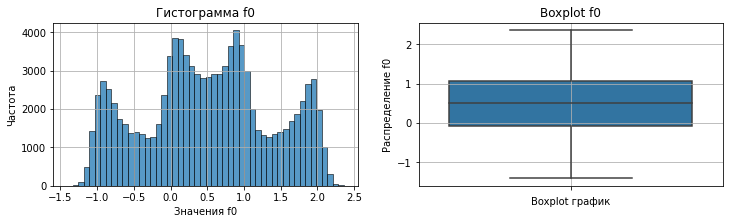

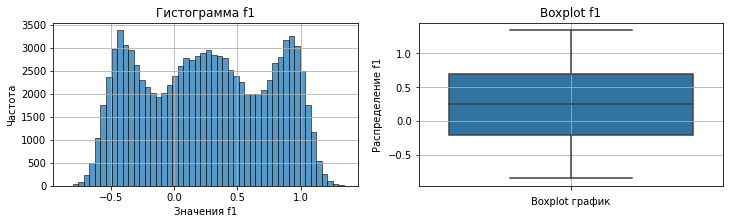

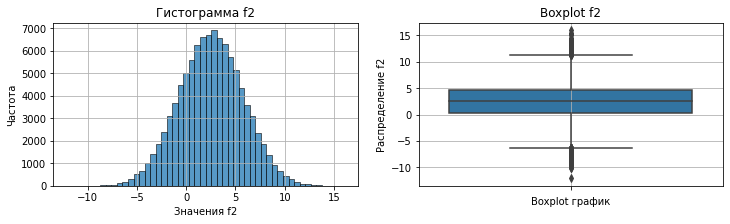

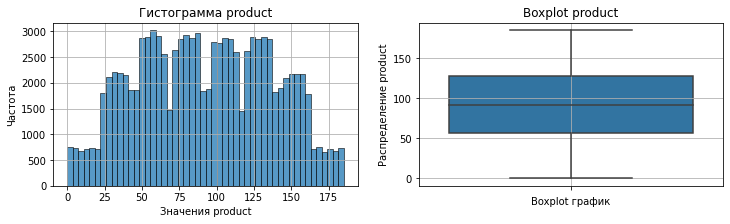

In [15]:
columns = list(geo_0.columns)
columns.remove('id')
num_plot(geo_0,columns)

In [16]:
geo_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


По результатам визуализационного и статистического анализа можно сделать следующие выводы:
* Признак f0 имеет ненормальное распределение с несколькими выраженными пиками. Медиана составляет 0.5, а межквартильный размах (IQR = 1.14) относительно медианы невелик, что говорит об умеренном разбросе. Boxplot демонстрирует широкое распределение, при этом выбросы отсутствуют.
* Признак f1 распределён аналогично f0. IQR равен 0.9. Медиана примерно равна среднему значению (0.25), что указывает на симметричность распределения. Разброс умеренный, выбросов не наблюдается.
* Признак f2 имеет распределение, близкое к нормальному. Среднее значение (2.5) немного меньше медианы (2.51), что указывает на очень слабую отрицательную асимметрию. Половина значений находится в диапазоне от 0.28 до 4.71 (IQR = 4.43). Максимум (16) значительно превышает верхнюю границу boxplot (11.355), а минимум (-12) — ниже нижней границы (-6.365), что указывает на наличие выбросов с обеих сторон.
* Распределение объёма нефти в скважинах является мультимодальным. Среднее значение (92.5) немного превышает медиану (91.8), что указывает на слабую положительную асимметрию (правосторонний перекос). Относительно низкие значения стандартного отклонения (44.2) и IQR (72) по сравнению со средним и медианой свидетельствуют о достаточно однородной выборке и умеренном разбросе. Boxplot визуализирует это широким, но не экстремальным диапазоном значений.

**Исследовательский анализ датасета *geo_1***

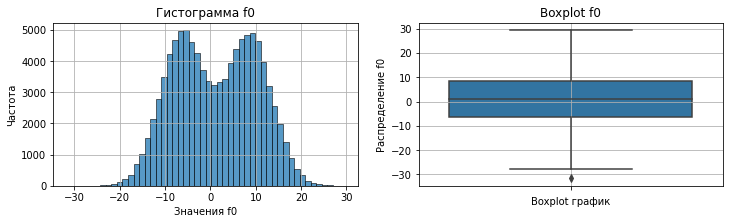

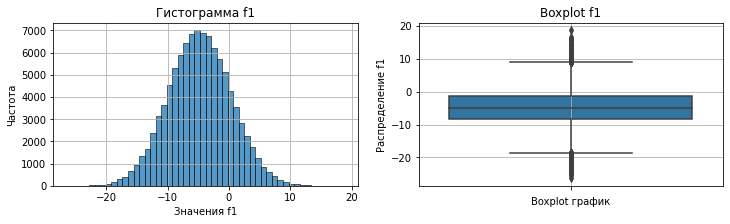

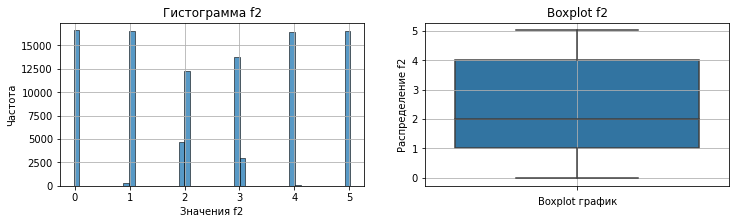

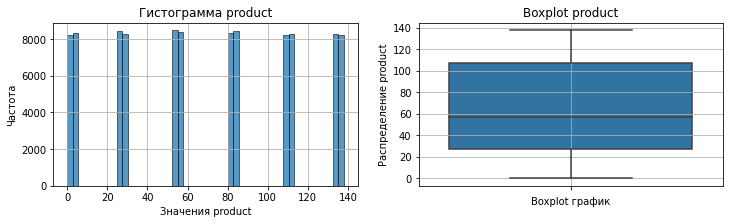

In [17]:
num_plot(geo_1,columns)

In [18]:
geo_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


В ходе визуализации распределения данных датасета geo_1 выяснилось, что:
* f0 имеет асимметричное распределение с левым «хвостом». Медиана (1.15) чуть выше среднего (1.14), что указывает на лёгкую отрицательную асимметрию. IQR = 14.92 (от -6.30 до 8.62), что говорит о широком разбросе. На Boxplot находится выброс в нижней части диапазона (мин.знач = -31.6).
* f1 распределён асимметрично с выраженной отрицательной асимметрией: среднее (-4.79) и медиана (-4.81). IQR = 6.93 — меньше, чем у f0. Boxplot демонстрирует выбросы с обеих сторон (мин.знач = -26.36, макс.знач = 18.73).
* f2 — дискретный и ограниченный признак, значения от ≈0 до 5. Распределение равномерное, мультимодальное, признаки нормальности отсутствуют. IQR = 3.0, медиана — 2.01, среднее — 2.49, присутствует слабая положительная асимметрия. Boxplot выбросов не показывает.
* product — мультимодальное распределение от 0 до 140 с равномерным размахом. Среднее (68.8) выше медианы (57.1), что указывает на слабо выраженную правостороннюю асимметрию. IQR = 80.86, разброс широкий. Boxplot не показывает ярких выбросов — данные распределены равномерно.

**Исследовательский анализ датасета *geo_2***

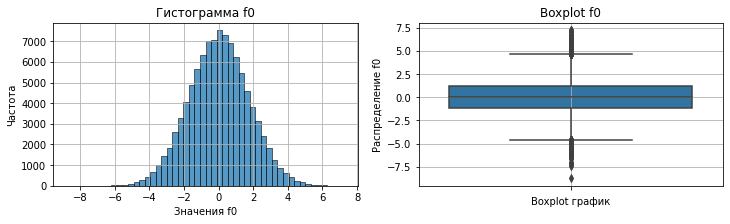

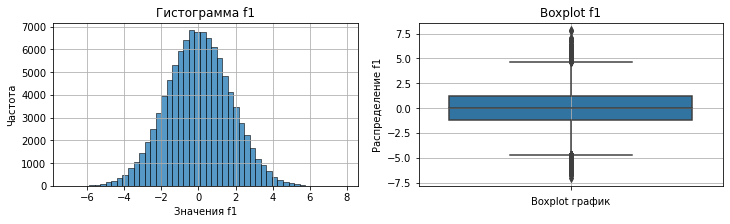

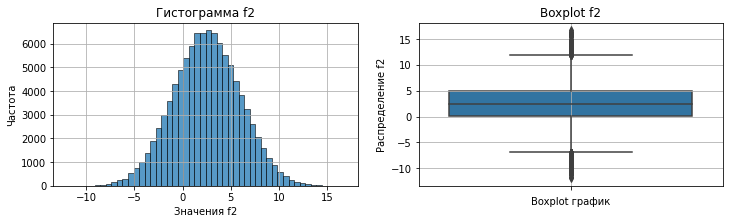

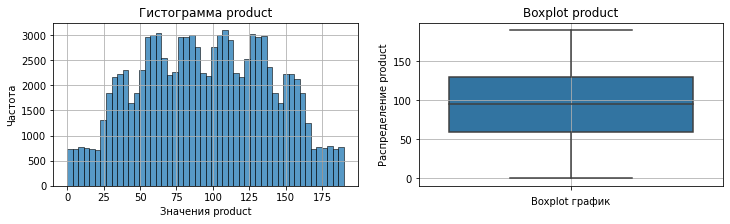

In [19]:
num_plot(geo_2,columns)

In [20]:
geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


* Распределение переменной f0 близко к нормальному, с чётко выраженной симметрией. Разница между средним (0.002 и медианой (0.009) минимальна. Разброс умеренный — межквартильный размах составляет 2.32. На boxplot видно несколько выбросов в нижней и верхней части диапазона, но основная масса значений сосредоточена в центре.
* Распределение f1 симметричное и приближено к нормальному. Среднее значение немного ниже медианы, но различие несущественное (–0.002 и –0.009 соответственно). IQR равен 2.34 — то есть масштаб разброса сопоставим с f0. На графике видны отдельные выбросы за границами усов графика, но в остальном признак устойчив и равномерен.
* У f2 наблюдается выраженная асимметрия вправо: распределение вытянуто в положительную сторону. Среднее значение (2.50) немного превышает медиану (2.48), что отражает правостороннюю скошенность. IQR равен 4.73. Boxplot указывает на наличие экстремальных наблюдений с обеих сторон, особенно в правом хвосте (максимум около 16.74).
* Распределение признака product многомодальное. Значения широко распределены по всему диапазону — от 0 до почти 190, что подтверждается большим межквартильным размахом (71.15). Несмотря на это, среднее и медиана почти совпадают (95.0 и 94.9), что говорит о визуальной симметрии. Явных выбросов нет, однако форма распределения может указывать на присутствие нескольких подгрупп внутри данных.

**Корреляционный анализ**

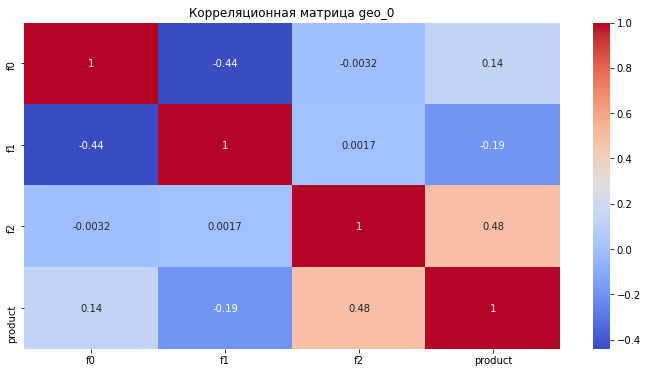

In [21]:
num_features = geo_0.drop(['id','product'],axis=1).columns
heatmap(geo_0,'geo_0')

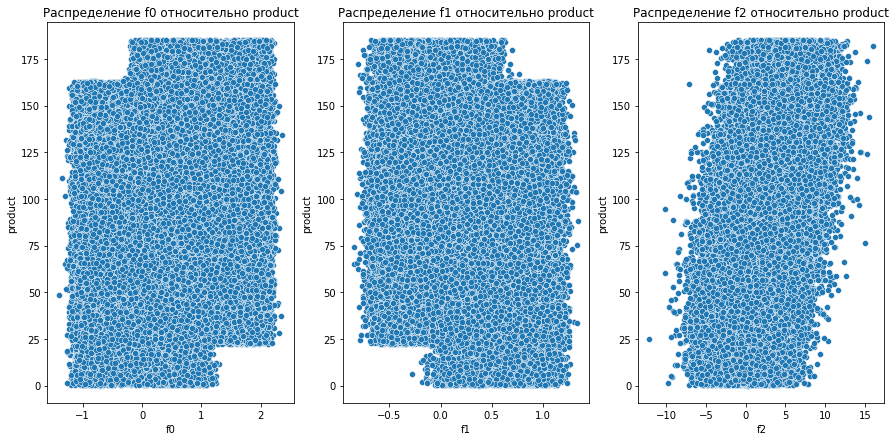

In [22]:
scatterplot(geo_0,num_features)

Корреляционная матрица geo_0 показала, что целевой признак имеет слабую линейную зависимость лишь с признаком f2(0.48). Мультиколлинеарность между входными признаками не наблюдается.

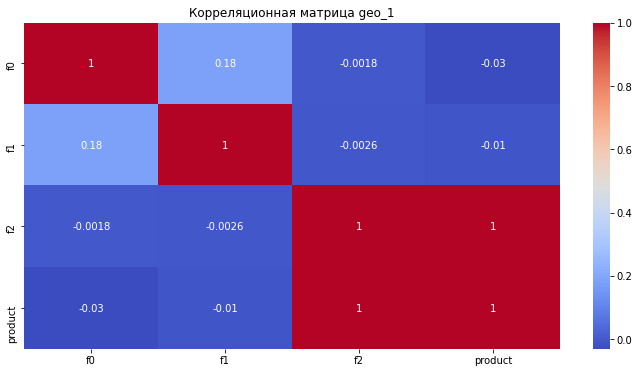

In [23]:
heatmap(geo_1,'geo_1')

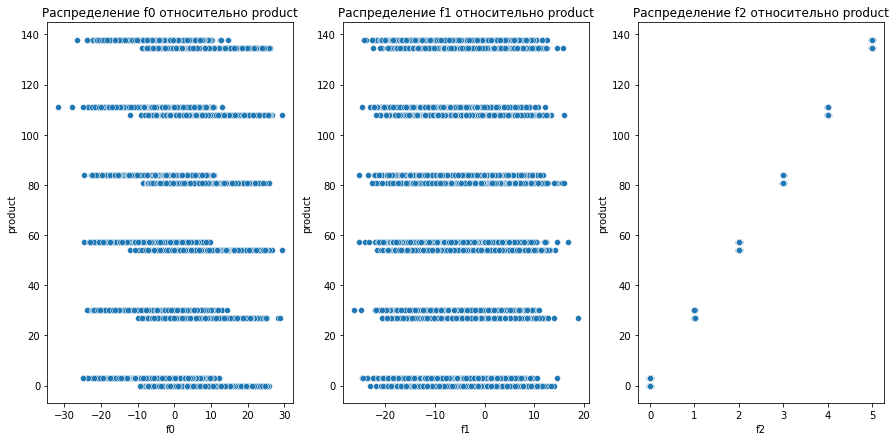

In [24]:
scatterplot(geo_1,num_features)

Из тепловой карты корреляций датасета geo_1 видно, что маскимальная взаимосвязь объёма нефти в скважине наблюдается с признаком f2 (1.0). Такое большое значение может указывать на утечку данных. Признаки f0 и f1 почти не оказывают никакого влияния на целевую переменную. 

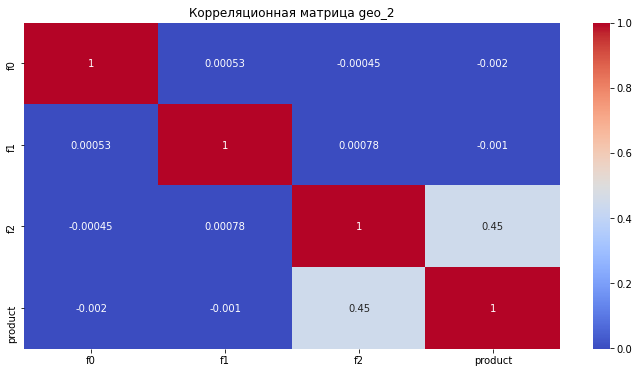

In [25]:
heatmap(geo_2,'geo_2')

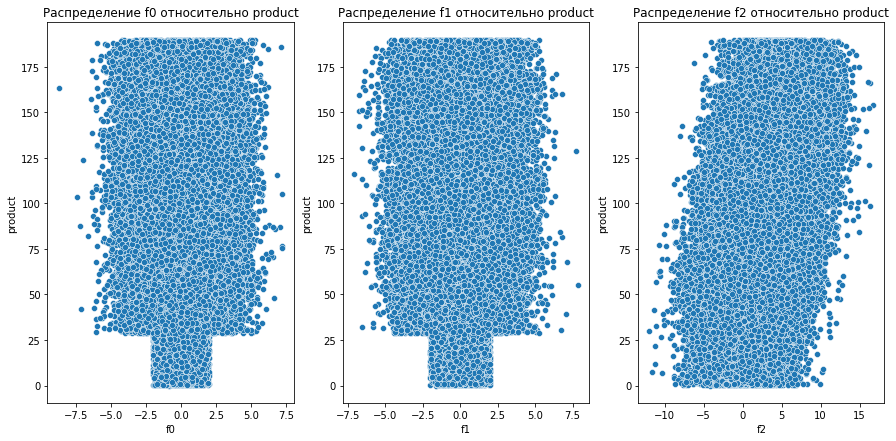

In [26]:
scatterplot(geo_2,num_features)

Аналогично другим архивам с данными в geo_2 отсутствует какая либо линейная взаимосвязь таргета с фичами f0 и f1, а признак f2 имеет корреляцию равную 0.45. Такая связь является не высокой, но значительной в котексте задачи. 

## Обучение и проверка модели

In [27]:
X_0 = geo_0[num_features]
y_0 = geo_0['product']

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

scores_0 = cross_val_score(
    pipeline,
    X_0,
    y_0,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

pipeline.fit(X_0, y_0)
pred_0 = pipeline.predict(X_0)
mean_pred_0 = pred_0.mean()

print('Метрика RMSE на кросс-валидации:', -np.mean(scores_0))
print('Средний запас предсказанного сырья:', mean_pred_0)

Метрика RMSE на кросс-валидации: 37.694272523439665
Средний запас предсказанного сырья: 92.50000000000001


Для подготвки данных для машинного обучения использовался метод масштабирования данных StandardScaler. Для оценки качества модели была использована метрика RMSE на кросс-валидации.

По результатам проверки на кросс-валидации метрика равняется 37.69. Средний запас сырья первого региона равен 92.5

In [28]:
X_1 = geo_1[num_features]
y_1 = geo_1['product']

scores_1 = cross_val_score(
    pipeline,
    X_1,
    y_1,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

pipeline.fit(X_1, y_1)
pred_1 = pipeline.predict(X_1)
mean_pred_1 = pred_1.mean()

print('Метрика RMSE на кросс-валидации:', -np.mean(scores_1))
print ('Средний запас предсказанного сырья:', mean_pred_1)

Метрика RMSE на кросс-валидации: 0.8904078994600948
Средний запас предсказанного сырья: 68.825


Для данных второго района метрика качества модели показала наилучший результат (0.89), но средний запас предсказанного сырья является наименьшим (68.82). Вероятно, такая точность связана с утечкой данных

In [29]:
X_2 = geo_2[num_features]
y_2 = geo_2['product']

scores_2 = cross_val_score(
    pipeline,
    X_2,
    y_2,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

pipeline.fit(X_2, y_2)
pred_2 = pipeline.predict(X_2)
mean_pred_2 = pred_2.mean()

print('Метрика RMSE на кросс-валидации:', -np.mean(scores_2))
print ('Средний запас предсказанного сырья:', mean_pred_2)

Метрика RMSE на кросс-валидации: 40.05687978485549
Средний запас предсказанного сырья: 95.00000000000006


Метрика RMSE на данных о третьем районе показала наименьшую точность (40.05). Средний запас предсказанного сырья является самым большим (95) из всех полученных, но разница в запасах сырья первого и третьего района - минимальна (95>92.5).

## Подготовка к расчёту прибыли

In [30]:
min_volume_for_profit = budget / (num_best_points * income_per_unit)
print(f'Минимальный объём для безубыточности: {min_volume_for_profit:.1f} тыс. баррелей')

Минимальный объём для безубыточности: 111.1 тыс. баррелей


Минимальный объём для бузубыточной разработки новой скважины равен 111.1 баррелей, а максимальный средний объём предсказанного сырья ревен 95. Следовательно, стоит выбрать 200 самых перспективные по запасу сырья скважин в каждом районе.

## Расчёт прибыли и рисков 

In [31]:
geo_0_max_profit = profit(geo_0['product'],pred_0)
print(f"Район 1 — суммарный объём сырья в 200 наиболее перспективных скважинах: \
{round((geo_0_max_profit+budget)/income_per_unit)} тыс. баррелей.")
print(f"Ожидаемая прибыль при разработке скважины: {round(geo_0_max_profit)} руб")

Район 1 — суммарный объём сырья в 200 наиболее перспективных скважинах: 29983 тыс. баррелей.
Ожидаемая прибыль при разработке скважины: 3492332480 руб


In [32]:
geo_1_max_profit = profit(geo_1['product'],pred_1)
print(f"Район 2 — суммарный объём сырья в 200 наиболее перспективных скважинах: \
{round((geo_1_max_profit+budget)/income_per_unit)} тыс. баррелей.")
print(f"Ожидаемая прибыль при разработке скважины: {round(geo_1_max_profit)} руб")

Район 2 — суммарный объём сырья в 200 наиболее перспективных скважинах: 27589 тыс. баррелей.
Ожидаемая прибыль при разработке скважины: 2415086697 руб


In [33]:
geo_2_max_profit = profit(geo_2['product'],pred_2)
print(f"Район 3 — суммарный объём сырья в 200 наиболее перспективных скважинах: \
{round((geo_2_max_profit+budget)/income_per_unit)} тыс. баррелей.")
print(f"Ожидаемая прибыль при разработке скважины: {round(geo_2_max_profit)} руб")

Район 3 — суммарный объём сырья в 200 наиболее перспективных скважинах: 28008 тыс. баррелей.
Ожидаемая прибыль при разработке скважины: 2603813861 руб


Среди трёх регионов наибольший суммарный объём сырья в 200 наиболее перспективных скважинах предсказывается в районе 0 - 29983 тыс. баррелей.
Это обеспечивает ему и наивысшую ожидаемую прибыль: 3492332480 рублей.
Следовательно, район 0 демонстрирует наилучший потенциал для инвестиций при текущих условиях.

In [34]:
income_0, quantile_0, risk_0 = bootstrap(geo_0['product'],pred_0)
lower_0 = quantile_0[0.025]
higher_0 = quantile_0[0.975]
mean_income_0 = income_0.mean()
print(f"Средняя прибыль региона geo_0: {round(mean_income_0)}")
print(f"Нижняя граница прибыли региона geo_0: {round(lower_0)} рублей, верхняя граница прибыли: {round(higher_0)} рублей")
print(f"Риск убытков региона geo_0: {round(risk_0,2)}%")

Средняя прибыль региона geo_0: 453901615
Нижняя граница прибыли региона geo_0: -37405670 рублей, верхняя граница прибыли: 1009689323 рублей
Риск убытков региона geo_0: 4.0%


In [35]:
income_1, quantile_1, risk_1 = bootstrap(geo_1['product'],pred_1)
lower_1 = quantile_1[0.025]
higher_1 = quantile_1[0.975]
mean_income_1 = income_1.mean()
print(f"Средняя прибыль региона geo_1 {round(mean_income_1)}")
print(f"Нижняя граница прибыли региона geo_1: {round(lower_1)} рублей, верхняя граница прибыли: {round(higher_1)} рублей")
print(f"Риск убытков региона geo_1: {round(risk_1,2)}%")

Средняя прибыль региона geo_1 465774093
Нижняя граница прибыли региона geo_1: 76086851 рублей, верхняя граница прибыли: 850051815 рублей
Риск убытков региона geo_1: 0.5%


In [36]:
income_2, quantile_2, risk_2 = bootstrap(geo_2['product'],pred_2)
lower_2 = quantile_2[0.025]
higher_2 = quantile_2[0.975]
mean_income_2 = income_2.mean()
print(f"Средняя прибыль региона geo_2: {round(mean_income_2)}")
print(f"Нижняя граница прибыли региона geo_2: {round(lower_2)} рублей, верхняя граница прибыли: {round(higher_2)} рублей")
print(f"Риск убытков региона geo_2: {round(risk_2,2)}%")

Средняя прибыль региона geo_2: 372529327
Нижняя граница прибыли региона geo_2: -63700170 рублей, верхняя граница прибыли: 866877020 рублей
Риск убытков региона geo_2: 6.0%


Наиболее предпочтительный регион для разработки скважин - geo_1. Он показывает наивысшую среднюю прибыль, минимальный риск убытков (0.5%) и уверенные границы доверительного интервала. Регион geo_0 менее стабилен, вероятность убытков сильно выше, нижняя граница прибыли в 6 раз меньше нижней границы geo_1(19_678_866 < 119_325_065), а разница верхних границ составляет 86_484_344, что абсолютно незначительно относительно всей прибыли и не стоит таких рисков (1_079_486_925 > 993_002_581). Разработка в регионе geo_2 нецелесообразна из-за высокого уровня неопределённости (вероятности риска = 4%) и потенциальных убытков (нижняя граница доверительного интервала = -60_489_755).

**Вывод:**

Цель проекта - определить наиболее перспективный регион для разработки нефтяных скважин на основе анализа трёх представленных датасетов.

1. Исходные данные
Все три набора данных оказались качественными: пропущенных значений и дубликатов не выявлено, предобработка не потребовалась.


2. Исследовательский и корреляционный анализ
Распределения и корреляция признаков показали различия по регионам:
    * В geo_0 и geo_2 переменные f0 и f1 распределены близко к нормальному, в geo_1 - сильно асимметричны.
    * Признак f2 в geo_1 имеет подозрительно высокую корреляцию с целевой переменной product (1.0), что может свидетельствовать о возможной утечке данных.
    * В остальных регионах f2 также показывает умеренную зависимость от целевой переменной (≈ 0.45 - 0.48), другие признаки - почти нейтральны.

3. Модель и прогнозирование
Была обучена модель машинного обучения для оценки запасов нефти. Для каждого региона рассчитан максимальный объём добычи и потенциальная прибыль в 200 самых перспективных скважинах.
Наибольшую прибыль показал регион geo_0 (3.49 млрд рублей), за ним следуют geo_2 и geo_1.


4. Bootstrap-анализ
Для оценки рисков и устойчивости прибыли проведён бутстрап (1000 выборок). Получены следующие результаты:

    * Geo_1: прибыль = 522 млн руб., риск убытков 0.5%
    * Geo_0: прибыль = 507 млн руб., риск 2.5%
    * Geo_2: прибыль = 418 млн руб., риск 4%

5. Рекомендация
Несмотря на чуть меньшую максимальную прибыль, регион geo_1 является наиболее надёжным для разработки скважины. Он показывает:
    * наивысшую прибыль
    * минимальный риск убытков
    * широкий и стабильный интервал доходности